In [1]:
%load_ext autoreload
%autoreload 2

## Notebook Description: Model Predictions on Cityscapes

This Jupyter notebook demonstrates the evaluation and visualization of trained segmentation models on the Cityscapes dataset. The notebook:
#
**Purpose**: Tests and visualizes predictions from pre-trained segmentation models UNet on urban street scene images from Cityscapes.
#
**Key Features**:
- Loads pre-trained models from checkpoints for the Cityscapes dataset
- Supports both from-scratch and fine-tuned model variants
- Generates predictions on the Cityscapes validation set and compares them with ground truth masks
- Provides side-by-side visualization of original images, ground truth masks, and model predictions
#
**Workflow**:
1. Configures dataset parameters and model paths for Cityscapes
2. Processes validation data and generates predictions
3. Visualizes results comparing original images, ground truth, and predictions
#
**Dataset**: Works with the Cityscapes semantic segmentation dataset, which contains 20 output classes for urban scene understanding.


In [2]:
from pathlib import Path
import sys
sys.path.append("..")
absolute_path = Path('..')


import matplotlib.pyplot as plt
import numpy as np
from Modules.CityscapeDataset.tools import decode_segmap
# %%
import os
from sys import path
path.append('..')
from Modules.Architecture import generate_model
from Modules.ModelXAI import generate_XAI_model

# generate dataloader for cityscapes
from Modules.CityscapeDataset.core import create_cityscapes_dataloaders
from Modules.CityscapeDataset.tools import decode_segmap
import torch

dataset_type='cityscapes'

_, val_loader, _  = create_cityscapes_dataloaders(
    root=absolute_path / "datasets" / "cityscapes",
    batch_size=1,
    num_workers=2,
    augment_train=None,
)


base_dir: str = f"../datasets/{dataset_type}"
device = 'cuda:0'
model_type = 'unet'

OUT_CHANNELS = 20
models_path = f"../models/{dataset_type}/{model_type}"
model_name = f"best_model.pth"


print(f"Loading model from {models_path}")
print(f"Model name: {model_name}")


# %%
print("Loading model...")
model = generate_model(
    model_type= model_type, 
    out_channels=OUT_CHANNELS, 
    load_from_checkpoint=True,
    models_path=models_path, 
    checkpoint_name=model_name
).eval().to(device)

# Prepare model for XAI
model = generate_XAI_model(model=model, device=device)

/mnt/backup/SegClarity/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model from ../models/cityscapes/unet
Model name: best_model.pth
Loading model...
../models/cityscapes/unet/best_model.pth
Model loaded successfully


In [3]:
for image_batch,mask_batch,names in val_loader:
    image_batch = image_batch.to(device)
    mask_batch = mask_batch.to(device)
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9999999964237213].
/tmp/ipykernel_1080458/1278573314.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


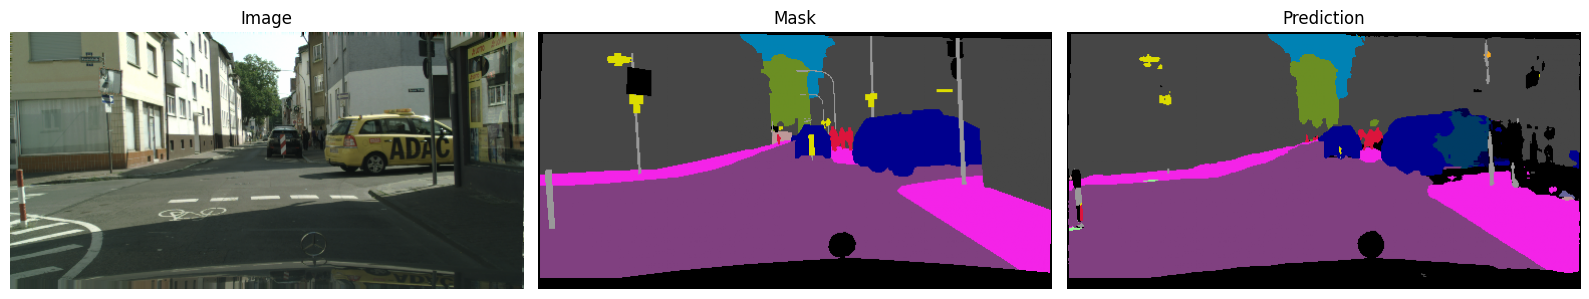

In [4]:
pred= model(image_batch).max(dim=1)[1]

fig, ax = plt.subplots(1, 3, figsize=(16, 10))
ax[0].imshow(image_batch[0].permute(1, 2, 0).detach().cpu().numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]));_ = ax[0].axis('off'); ax[0].set_title('Image')
ax[1].imshow(decode_segmap(mask_batch[0].detach().cpu()));_ = ax[1].axis('off'); ax[1].set_title('Mask')
ax[2].imshow(decode_segmap(pred[0].detach().cpu()));_ = ax[2].axis('off'); ax[2].set_title('Prediction')
fig.tight_layout()
fig.show()


Computing attributions for target 1


/mnt/backup/SegClarity/.venv/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/mnt/backup/SegClarity/.venv/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9999999964237213].
/mnt/backup/SegClarity/Notebooks/../Modules/Utils/core.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_max = torch.tensor(v_max, device=v.device, dtype=v.dtype)
/mn

Computing attributions for target 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9999999964237213].


Computing attributions for target 12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9999999964237213].


Computing attributions for target 14


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9999999964237213].


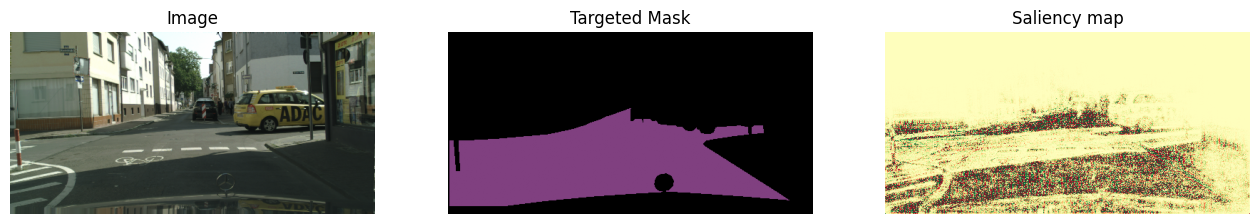

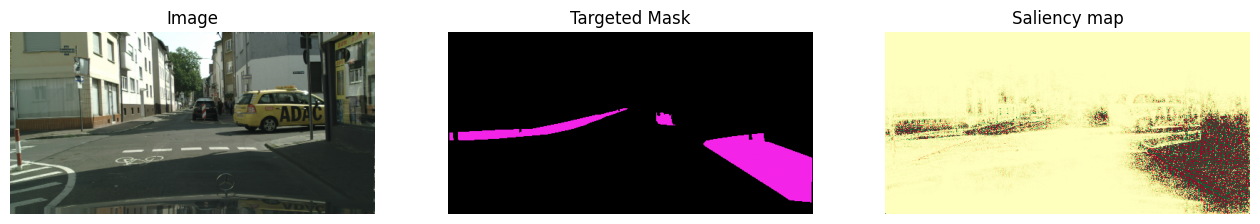

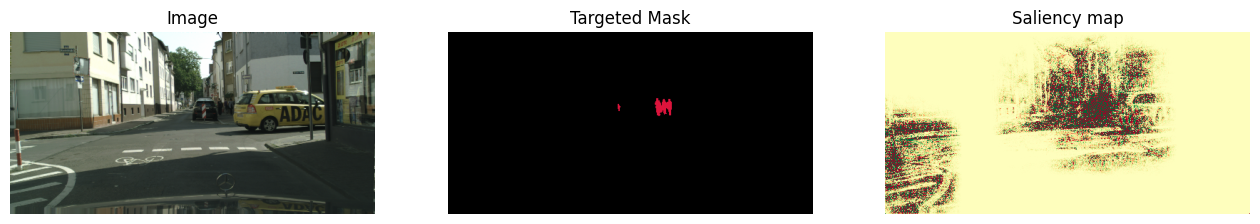

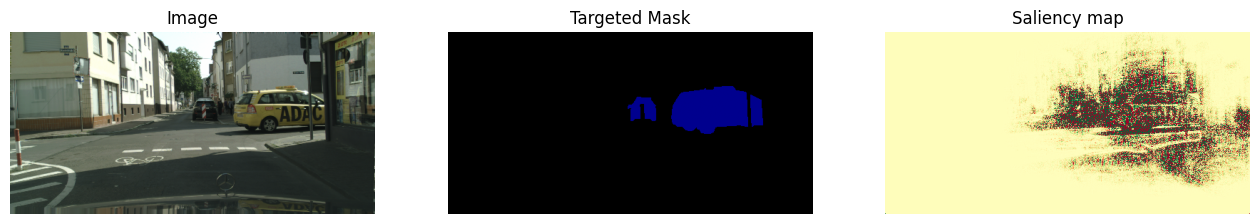

In [5]:
from Modules.Attribution.core import generateAttributionsOnInput
from Modules.Utils import clip_fixed_percentage
from Modules.Visualization.core import generate_heatmap
from Modules.Utils import Normalizations
import matplotlib.pyplot as plt


targets = [1, 2 , 12 , 14] # street, sidewalk, person, car
device = "cuda:0"
debug = False
kwargs = {"layer": model.final_layer}
methods = ["GuidedGradCam", "LRP", "InputXGradient", "DeepLift"]
method = methods[3] # GuidedGradCam, LRP, InputXGradient, DeepLift

for selected_target in targets:
    print(f"Computing attributions for target {selected_target}")
    attr = generateAttributionsOnInput(image_batch, model, selected_target, method, device=device, debug=debug, **kwargs).detach().cpu()
    attr_sum = attr.sum(dim=1, keepdim=True).squeeze()
    attr_sum = clip_fixed_percentage(attr_sum, p=0.05)
    fig,axes = plt.subplots(1,3,figsize=(16,3))

    targeted_mask = torch.where(mask_batch == selected_target, torch.ones_like(mask_batch), torch.zeros_like(mask_batch)).squeeze().detach().cpu()

    axes[0].imshow(image_batch[0].permute(1, 2, 0).detach().cpu().numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]));_ = axes[0].axis('off'); axes[0].set_title('Image')
    axes[1].imshow(decode_segmap((targeted_mask * selected_target).squeeze().detach().cpu()));_ = axes[1].axis('off'); axes[1].set_title('Targeted Mask')

    generate_heatmap((attr_sum - attr_sum.mean()).squeeze().detach().cpu(),fig=fig,ax=axes[2],normalization_name=Normalizations.normalize_non_shifting_zero);_ = axes[2].axis('off'); _ = axes[2].set_title('Saliency map')